# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, max, lit, when, col, count
from pyspark.sql.types import *


import datetime
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("EDA  Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "./mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
### Find empty user strings and remove them from the dataset
user_log.select(['userId']).dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [6]:
print(user_log.count())
user_log = user_log.filter(user_log.userId != "") #on the mini data 
print(user_log.count())

286500
278154


In [7]:
### Check the user agent column
user_log.select(['userAgent']).dropDuplicates().sort('userAgent').show()

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [8]:
### Double check
user_log.filter(user_log.userAgent == "").count()

0

In [9]:
### Check and double check location
print(user_log.select(['location']).dropDuplicates().sort('location').show())
print(user_log.filter(user_log.location == "").count())

+--------------------+
|            location|
+--------------------+
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
|Cincinnati, OH-KY-IN|
+--------------------+
only showing top 20 rows

None
0


In [10]:
### EDA
# 1. Define Churn
# 2. Create Visualizations
## a. Bar graph of churn data by browser
## b. Bar graph of churn data by location
## c. Box and whisker of thumbs up per day for churned users
## d. Box and whikser of thumbs up per day for non-churned users

In [11]:
user_log.filter("page = 'Cancellation Confirmation'").show(5,False)

+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------+------+
|artist|auth     |firstName|gender|itemInSession|lastName|length|level|location                                   |method|page                     |registration |sessionId|song|status|ts           |userAgent                                                                                                                                  |userId|
+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+--------------------------------------------------------------------------------------------------------------

In [12]:
# add churn, 1 or 0
churned = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
user_log = user_log.withColumn("Churned", churned("page"))

# add churn user flag
user_log = user_log.withColumn("userChurned", max('Churned').over(Window.partitionBy('UserId')))


In [13]:
print(user_log.filter(user_log['userChurned'] == 1).count())
print(user_log.filter(user_log['Churned'] == 1).count())

44864
52


In [14]:
ua_list = user_log.select(['userAgent']).collect()

ua_list = [re.search(r'\(([^\)]*)\)', str(i[0]) )[0].split(';')[0].replace('(', '').replace(')', '') for i in ua_list]
ua_list = list(dict.fromkeys(ua_list))
print(ua_list)


['Windows NT 6.1', 'Macintosh', 'Windows NT 6.0', 'Windows NT 6.2', 'iPhone', 'Windows NT 6.3', 'iPad', 'compatible', 'X11', 'Windows NT 5.1']


In [15]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

get_browser_udf = udf(get_browser, StringType())


def get_platform(x):
    if 'compatible' in x:
        return 'Windows'
    elif 'iPad' in x:
        return 'iPad'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'Macintosh' in x:
        return 'Mac'
    elif 'Windows NT 5.1' in x:
        return 'Windows'
    elif 'Windows NT 6.0' in x:
        return 'Windows'
    elif 'Windows NT 6.1' in x:
        return 'Windows'
    elif 'Windows NT 6.2' in x:
        return 'Windows'
    elif 'Windows NT 6.3' in x:
        return 'Windows'
    elif 'X11' in x:
        return 'Linux'
    
get_platform_udf = udf(get_platform, StringType())

In [16]:
user_log = user_log.withColumn( 'browser', get_browser_udf(user_log.userAgent) )
user_log = user_log.withColumn( 'platform', get_platform_udf(user_log.userAgent) )

In [17]:
user_log.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churned=0, userChurned=0, browser='Safari', platform='iPhone'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X

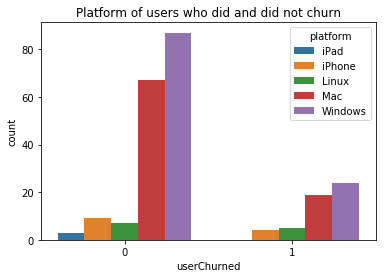

In [18]:
churned_platform_group = user_log.drop_duplicates(['userId', 'platform']).groupby(['userChurned', 'platform']).count().sort("userChurned").toPandas()

plt.figure()
plt.title('Platform of users who did and did not churn')
sb.barplot( x = 'userChurned', y = 'count', data = churned_platform_group, hue = 'platform' )
plt.show()

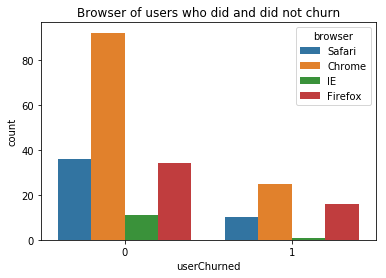

In [19]:
churned_platform_group = user_log.drop_duplicates(['userId', 'browser']).groupby(['userChurned', 'browser']).count().sort("userChurned").toPandas()

plt.figure()
plt.title('Browser of users who did and did not churn')
sb.barplot( x = 'userChurned', y = 'count', data = churned_platform_group, hue = 'browser' )
plt.show()

In [20]:
def get_state(x):
    return x.split(', ')[1]

get_state_udf = udf(get_state, StringType())

def get_city(x):
    return x.split(', ')[0]

get_city_udf = udf(get_city, StringType())

In [21]:
user_log = user_log.withColumn( 'state', get_state_udf(user_log.location) )
user_log = user_log.withColumn( 'city', get_city_udf(user_log.location) )
user_log.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churned=0, userChurned=0, browser='Safari', platform='iPhone', state='CT', city='Bridgeport-Stamford-Norwalk'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozill

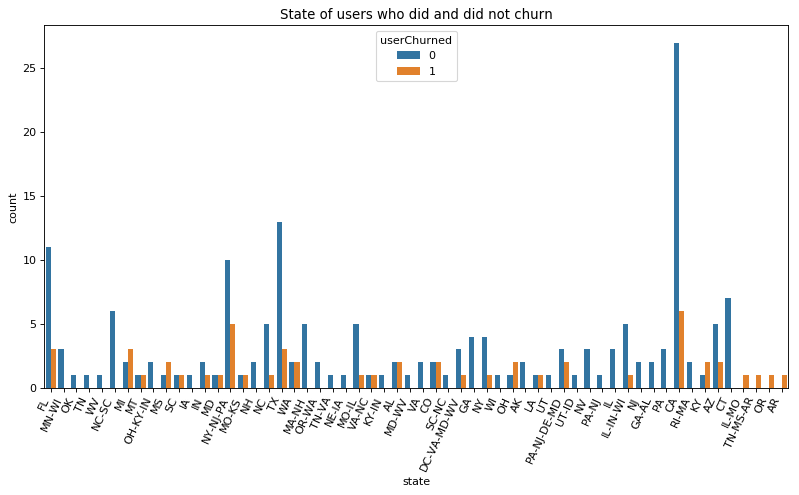

In [22]:
churned_state_group = user_log.drop_duplicates(['userId', 'state']).groupby(['userChurned', 'state']).count().sort("userChurned").toPandas()

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('State of users who did and did not churn')
sb.barplot( x = 'state', y = 'count', data = churned_state_group, hue = 'userChurned' )
plt.xticks(rotation=65, horizontalalignment='right')
plt.show()

In [23]:
get_hour = udf(lambda x: math.floor( (x / 1000.0) / (60*60*24) ) )
user_log = user_log.withColumn("uniqueDay", get_hour(user_log.ts))
user_log.take(5)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Churned=0, userChurned=0, browser='Safari', platform='iPhone', state='CT', city='Bridgeport-Stamford-Norwalk', uniqueDay='17812'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000,

In [24]:
total_daily_sessions_df = user_log.select('userId', 'sessionId', 'uniqueDay').groupby(['userId', 'uniqueDay']).agg(count('sessionId').alias('totalDailySessions')).sort('userId')
avg_daily_sessions_df = total_daily_sessions_df.groupBy('userId').avg('totalDailySessions').withColumnRenamed('avg(totalDailySessions)', 'avgDailySessions')

user_log = user_log.join(total_daily_sessions_df, on=['userId', 'uniqueDay'])
user_log = user_log.join(avg_daily_sessions_df, on='userId')

user_log.take(5)


[Row(userId='100010', uniqueDay='17840', artist='Ron Carter', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=497.13587, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=133, song="I CAN'T GET STARTED", status=200, ts=1541411290000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', Churned=0, userChurned=0, browser='Safari', platform='iPhone', state='CT', city='Bridgeport-Stamford-Norwalk', totalDailySessions=72, avgDailySessions=54.42857142857143),
 Row(userId='100010', uniqueDay='17840', artist='Limi-T 21', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=254.79791, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=133, song='Si Supi

In [25]:
avg_daily_session_pd = user_log.select(['userId','avgDailySessions','userChurned']).drop_duplicates(['userId']).sort("userChurned").toPandas()

avg_daily_session_pd




,userId,avgDailySessions,userChurned
0,100010,54.428571,0
1,200002,67.714286,0
2,124,146.212121,0
3,7,25.125000,0
4,15,119.894737,0
5,155,125.250000,0
6,132,109.714286,0
7,154,39.333333,0
8,11,53.000000,0
9,138,145.235294,0


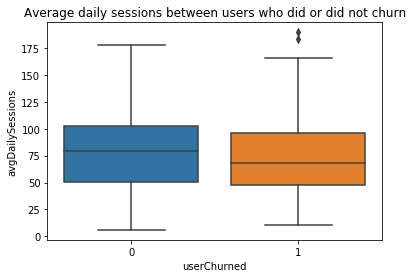

In [26]:
plt.figure()
sb.boxplot(y="avgDailySessions", x="userChurned", data=avg_daily_session_pd)
plt.title('Average daily sessions between users who did or did not churn')
plt.show()



In [27]:
print(user_log.select(['page']).dropDuplicates().sort('page').show())

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+

None


In [28]:
# There is an issue with running joins with dataframes that were created from a clone
# The issue was revolving around the 'uniqueDay' column, so I renamed it with the same name
# https://stackoverflow.com/questions/45713290/how-to-resolve-the-analysisexception-resolved-attributes-in-spark
total_daily_thumbs_up_df = user_log.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == 'Thumbs Up', 1)).alias('totalDailyThumbsUp')).sort('userId')
avg_daily_thumbs_up_df = total_daily_thumbs_up_df.groupBy('userId').avg('totalDailyThumbsUp').withColumnRenamed('avg(totalDailyThumbsUp)', 'avgDailyThumbsUp')

user_log = user_log.join(total_daily_thumbs_up_df, on=['userId', 'uniqueDay'])
user_log = user_log.join(avg_daily_thumbs_up_df, on='userId')




avg_daily_thumbs_up_pd = user_log.select(['userId','avgDailyThumbsUp','userChurned']).drop_duplicates(['userId']).sort("userChurned").toPandas()


print(user_log.take(3))



[Row(userId='100010', uniqueDay='17840', artist='Ron Carter', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=497.13587, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=133, song="I CAN'T GET STARTED", status=200, ts=1541411290000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', Churned=0, userChurned=0, browser='Safari', platform='iPhone', state='CT', city='Bridgeport-Stamford-Norwalk', totalDailySessions=72, avgDailySessions=54.42857142857143, totalDailyThumbsUp=4, avgDailyThumbsUp=2.4285714285714284), Row(userId='100010', uniqueDay='17840', artist='Limi-T 21', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=254.79791, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong'

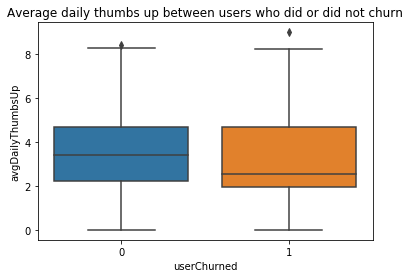

In [29]:
plt.figure()
sb.boxplot(y="avgDailyThumbsUp", x="userChurned", data=avg_daily_thumbs_up_pd)
plt.title('Average daily thumbs up between users who did or did not churn')
plt.show()

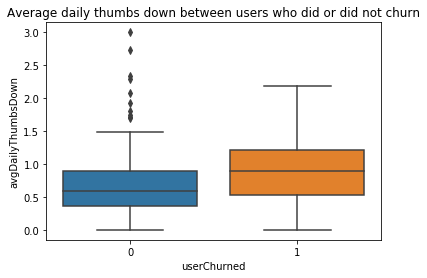

In [30]:
total_daily_thumbs_down_df = user_log.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == 'Thumbs Down', 1)).alias('totalDailyThumbsDown')).sort('userId')
avg_daily_thumbs_down_df = total_daily_thumbs_down_df.groupBy('userId').avg('totalDailyThumbsDown').withColumnRenamed('avg(totalDailyThumbsDown)', 'avgDailyThumbsDown')

user_log = user_log.join(total_daily_thumbs_down_df, on=['userId', 'uniqueDay'])
user_log = user_log.join(avg_daily_thumbs_down_df, on='userId')




avg_daily_thumbs_down_pd = user_log.select(['userId','avgDailyThumbsDown','userChurned']).drop_duplicates(['userId']).sort("userChurned").toPandas()




plt.figure()
sb.boxplot(y="avgDailyThumbsDown", x="userChurned", data=avg_daily_thumbs_down_pd)
plt.title('Average daily thumbs down between users who did or did not churn')
plt.show()



In [31]:
total_daily_errors_df = user_log.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == 'Error', 1)).alias('totalDailyErrors')).sort('userId')
user_log = user_log.join(total_daily_errors_df, on=['userId', 'uniqueDay'])

total_daily_advertisements_df = user_log.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == 'Roll Advert', 1)).alias('totalDailyAdvertisements')).sort('userId')
user_log = user_log.join(total_daily_advertisements_df, on=['userId', 'uniqueDay'])

total_daily_next_songs_df = user_log.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == 'NextSong', 1)).alias('totalDailyNextSong')).sort('userId')
user_log = user_log.join(total_daily_next_songs_df, on=['userId', 'uniqueDay'])


In [32]:
user_log.take(5)

[Row(userId='100019', uniqueDay='17811', artist=None, auth='Logged In', firstName='Angel', gender='M', itemInSession=3, lastName='Jacobs', length=None, level='free', location='Spokane-Spokane Valley, WA', method='GET', page='Home', registration=1536257455000, sessionId=71, song=None, status=200, ts=1538942626000, userAgent='Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31.0) Gecko/20100101 Firefox/31.0', Churned=0, userChurned=1, browser='Firefox', platform='Linux', state='WA', city='Spokane-Spokane Valley', totalDailySessions=61, avgDailySessions=44.5, totalDailyThumbsUp=1, avgDailyThumbsUp=0.5, totalDailyThumbsDown=0, avgDailyThumbsDown=0.5, totalDailyErrors=0, totalDailyAdvertisements=10, totalDailyNextSong=43),
 Row(userId='100019', uniqueDay='17811', artist='I-Wayne', auth='Logged In', firstName='Angel', gender='M', itemInSession=4, lastName='Jacobs', length=246.282, level='free', location='Spokane-Spokane Valley, WA', method='PUT', page='NextSong', registration=1536257455000, sessio

In [33]:
user_log.printSchema()

# uniqueDay (num)
# level (cat)
# page (cat)
# browser (cat)
# platform (cat)
# state (cat)
# city (cat)
# totalDailySessions (num)
# avgDailySessions (num)
# totalDailyThumbsUp (num)
# avgDailyThumbsUp (num)
# totalDailyThumbsDown (num)
# avgDailyThumbsDown (num)
# totalDailyErrors (num)
# totalDailyAdvertisements (num)
# totalDailyNextSong (num)

root
 |-- userId: string (nullable = true)
 |-- uniqueDay: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churned: integer (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- totalDailySessions: long

In [34]:
# Prepare data for models
user_log = user_log.drop('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'location', 'method', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'Churned')

user_log.printSchema()

root
 |-- userId: string (nullable = true)
 |-- uniqueDay: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- totalDailySessions: long (nullable = false)
 |-- avgDailySessions: double (nullable = true)
 |-- totalDailyThumbsUp: long (nullable = false)
 |-- avgDailyThumbsUp: double (nullable = true)
 |-- totalDailyThumbsDown: long (nullable = false)
 |-- avgDailyThumbsDown: double (nullable = true)
 |-- totalDailyErrors: long (nullable = false)
 |-- totalDailyAdvertisements: long (nullable = false)
 |-- totalDailyNextSong: long (nullable = false)



In [35]:
user_log = user_log.withColumn("uniqueDayTmp", user_log.userId.cast(IntegerType())).drop("uniqueDay").withColumnRenamed("uniqueDayTmp", "uniqueDay")


user_log.printSchema()


root
 |-- userId: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- totalDailySessions: long (nullable = false)
 |-- avgDailySessions: double (nullable = true)
 |-- totalDailyThumbsUp: long (nullable = false)
 |-- avgDailyThumbsUp: double (nullable = true)
 |-- totalDailyThumbsDown: long (nullable = false)
 |-- avgDailyThumbsDown: double (nullable = true)
 |-- totalDailyErrors: long (nullable = false)
 |-- totalDailyAdvertisements: long (nullable = false)
 |-- totalDailyNextSong: long (nullable = false)
 |-- uniqueDay: integer (nullable = true)



In [36]:
## Create pipeline for processing data

# pipeline_stages = [StringIndexer(inputCol=column, outputCol=column+"Index") 
#                     for column in ['level','page','browser', 'platform', 'state', 'city'] ]
pipeline_stages = [StringIndexer(inputCol=column, outputCol=column+"Index") 
                    for column in ['level','page','browser', 'platform', 'state'] ]

assembler = VectorAssembler(inputCols=['uniqueDay', 'totalDailySessions', 'avgDailySessions', 'totalDailyThumbsUp', 'avgDailyThumbsUp', 'totalDailyThumbsDown', 'avgDailyThumbsDown', 'totalDailyErrors', 'totalDailyAdvertisements', 'totalDailyNextSong'], outputCol="features")
pipeline_stages.append(assembler)

standard_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
pipeline_stages.append(standard_scaler)

# combined_assembler = VectorAssembler(inputCols=['scaledFeatures','levelIndex', 'pageIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex'], outputCol='combinedFeatures')
combined_assembler = VectorAssembler(inputCols=['scaledFeatures','levelIndex', 'pageIndex', 'browserIndex', 'platformIndex', 'stateIndex'], outputCol='combinedFeatures')
pipeline_stages.append(combined_assembler)

process_pipeline = Pipeline(stages=pipeline_stages)






In [37]:
user_log_model = process_pipeline.fit(user_log).transform(user_log)

user_log_model = user_log_model.select('userChurned','combinedFeatures').withColumnRenamed('userChurned', 'label')

train, test = user_log_model.randomSplit([0.8, 0.2], seed=42)


### Renamed userChurned to label

In [38]:


# log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="userChurned", maxIter=10)

log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="label", maxIter=10)

fitted_log_model = log_reg.fit(train)

log_results = fitted_log_model.transform(test)

In [39]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

#f1_score = f1_evaluator.evaluate(log_results.select(col('userChurned').alias('label'), col('prediction')))
f1_score = f1_evaluator.evaluate(log_results.select(col('label'), col('prediction')))

print('The F1 score on the test set is {:.2%}'.format(f1_score)) 

The F1 score on the test set is 76.26%


In [40]:
gbt = GBTClassifier(featuresCol="combinedFeatures", labelCol="label", maxIter=10, maxBins=120)

fitted_gbt_model = gbt.fit(train)

gbt_results = fitted_gbt_model.transform(test)

In [41]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

f1_score = f1_evaluator.evaluate(gbt_results.select(col('label'), col('prediction')))

print('The F1 score on the test set is {:.2%}'.format(f1_score)) 

The F1 score on the test set is 99.37%


In [42]:
rf = RandomForestClassifier(featuresCol="combinedFeatures", labelCol="label", maxBins=120)

fitted_rf_model = rf.fit(train)

rf_results = fitted_rf_model.transform(test)

In [43]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

f1_score = f1_evaluator.evaluate(rf_results.select(col('label'), col('prediction')))

print('The F1 score on the test set is {:.2%}'.format(f1_score))

The F1 score on the test set is 91.98%


In [44]:
auc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
roc_value = auc_evaluator.evaluate(gbt_results)
print('The areaUnderROC on the test set for the GBT model is {:.2%}'.format(roc_value))

The areaUnderROC on the test set for the GBT model is 99.97%


In [45]:
roc_value = auc_evaluator.evaluate(rf_results)
print('The areaUnderROC on the test set for the RF model is {:.2%}'.format(roc_value))

The areaUnderROC on the test set for the RF model is 99.40%


In [46]:
gbt_param_grid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10]).addGrid(gbt.maxIter, [10, 20]).build()
cross_validator = CrossValidator(estimator = gbt, estimatorParamMaps = gbt_param_grid, evaluator = MulticlassClassificationEvaluator(metricName='f1'), numFolds = 3)



In [47]:
cv_model = cross_validator.fit(train)
cv_results = cv_model.transform(test)



In [48]:
f1_score = f1_evaluator.evaluate(cv_results.select(col('label'), col('prediction')))
print('The F1 score on the test set for the hypertuned GBT model is {:.2%}'.format(f1_score)) 



The F1 score on the test set for the hypertuned GBT model is 100.00%


In [49]:
roc_value = auc_evaluator.evaluate(cv_results)
print('The areaUnderROC on the test set for the hypertuned GBT model is {:.2%}'.format(roc_value))

The areaUnderROC on the test set for the hypertuned GBT model is 100.00%


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

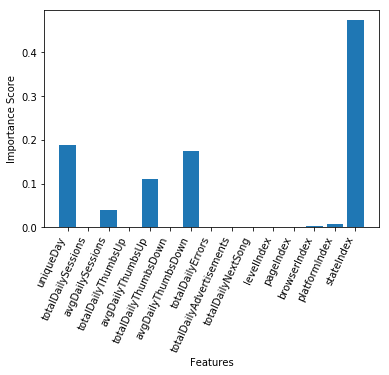

In [50]:
cv_feature_vals = cv_model.bestModel.featureImportances.values
# feature_cols = ['uniqueDay', 'totalDailySessions', 'avgDailySessions', 'totalDailyThumbsUp', 'avgDailyThumbsUp', 'totalDailyThumbsDown', 'avgDailyThumbsDown', 'totalDailyErrors', 'totalDailyAdvertisements', 'totalDailyNextSong','levelIndex', 'pageIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex']
feature_cols = ['uniqueDay', 'totalDailySessions', 'avgDailySessions', 'totalDailyThumbsUp', 'avgDailyThumbsUp', 'totalDailyThumbsDown', 'avgDailyThumbsDown', 'totalDailyErrors', 'totalDailyAdvertisements', 'totalDailyNextSong','levelIndex', 'pageIndex', 'browserIndex', 'platformIndex', 'stateIndex']

x_pos = np.arange(len(feature_cols))
 
plt.bar(x_pos, cv_feature_vals, align='center')
plt.xticks(x_pos, feature_cols)
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.xticks(rotation=65, horizontalalignment='right')


# Wow cityIndex was a very strong indicator!... Maybe, that's why I have 100% accuracy?
# Rerunning, and removing cityIndex

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [ ]:
# EDA plan
## 0. Define Churn
## 1. Clean user string of empty values
## 2. Check user agent for missing values and remove those rows

# Feature Engineering Plan
## 1. Split UA into browser and platform columns
## 2. Create column for unique days
## 3. Create column for average session length per day
## 4. Create column for total sessions per day
## 5. Create column for total advertisements per day
## 6. Create column for total next song actions per day
## 7. Create column for total error actions per day
## 8. Create column for total thumbs up per day
## 9. Create column for total thumbs down per day

## Somewhere in this I need to figure out visualizations

In [ ]:
user_log.select("auth").dropDuplicates().show()

In [ ]:
user_log.where(user_log.userId == 30).collect()[0]

In [ ]:
print( datetime.datetime.fromtimestamp( user_log.where(user_log.userId == 30).collect()[0]['ts']/1000 ) )

In [ ]:
# Don't use datetime object, instead create a column that tracks the unique day through the timestamp
## Divide by 1000, then 60, then 60, then 24
get_hour = udf(lambda x: math.floor( (x / 1000.0) / (60*60*24) ) )
user_log = user_log.withColumn("unique_day", get_hour(user_log.ts))

In [ ]:
user_log.take(5)

In [ ]:
# Get average number of ongs listened to per day
## Average <metric> per day should be a decent predictor of churn

In [ ]:
# Do data cleaning
## Remove "" as a user ID
## Other anomalies??

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# I want to look for whether or not a user came back to the service, on a given day
## Create hour column
## Count the number of days that a user starts at least 1 session
### Maybe better here to create colum that is the number of days since creating an account
#### How do I know when an account has been created?
#### What about users that already have accounts?
## Create columns to track when the desired logging in, logging out, and logging back in happen
### Is this the only kind of user journey that I want to look at?

## Maybe, sessions per day is fine



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.